In [1]:
####importing packages
import sys
sys.path.append('/work/mh0731/m300876/package')
import interp3d
import icons
from pathlib import Path
import importlib
import numpy as np
import xarray as xr
from distributed import Client, progress, wait # Libaray to orchestrate distributed resources\

/sw/spack-levante/mambaforge-4.11.0-0-Linux-x86_64-sobz6z/lib/python3.9/site-packages/dask_jobqueue/core.py:20: FutureWarning: tmpfile is deprecated and will be removed in a future release. Please use dask.utils.tmpfile instead.
  from distributed.utils import tmpfile


In [2]:
import dask # Distributed data libary

In [3]:
icons.prepare_cpu(memory='128GB',nworker=1)

Number of CPUs: 256, number of threads: 256, number of workers: 1, processes: False


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Workers: 1
Total threads: 256,Total memory: 119.21 GiB
Status: running,Using processes: False
Comm: inproc://136.172.120.208/580472/1,Workers: 1
Dashboard: /user/m300876/levante-spawner-advanced//proxy/8787/status,Total threads: 256
Started: Just now,Total memory: 119.21 GiB
Comm: inproc://136.172.120.208/580472/4,Total threads: 256
Dashboard: /user/m300876/levante-spawner-advanced//proxy/37497/status,Memory: 119.21 GiB
Nanny: None,


**Interpolate data**

In [4]:
def add_coord_var(darray,gridset):
    clon_x = xr.DataArray(gridset.clon.values,
                      dims=gridset.clon.dims,attrs={k:v for k,v in gridset.clon.attrs.items()})
    clat_y = xr.DataArray(gridset.clat.values,
                      dims=gridset.clat.dims,attrs={k:v for k,v in gridset.clat.attrs.items()})
    dset = darray.rename({'ncells':'cell'}).assign_coords(clon=clon_x,clat=clat_y).to_dataset()
    dset['clon_vertices'] = gridset.clon_vertices 
    dset['clat_vertices'] = gridset.clat_vertices 
    return dset

In [5]:
def cut_gridset(grid_file,x_first,y_first,x_end,y_end):
    gridset = xr.open_dataset(grid_file,chunks='auto')
    factor = 1/180*np.pi
    return gridset.where(((gridset.clon>(x_first*factor)) & (gridset.clon<(x_end*factor))) & (
        (gridset.clat>(y_first*factor)) & (gridset.clat<(y_end*factor))),drop=True) 

In [6]:
def interp_data(darray, x_res, y_res,x_first,y_first,x_end,y_end,grid_file,weights=None):
    gridset = cut_gridset(grid_file,x_first,y_first,x_end,y_end)
    dset= add_coord_var(darray,gridset)
    ###interpolation
    remap_var = interp3d.remap_cut(dset, x_res, y_res,x_first,y_first,x_end,y_end,grid_file)
    remap_jobs = dask.persist(remap_var)
    progress(remap_jobs, notebook=False)
    var_final = dask.compute(remap_var)
    return var_final[0]

**ngc2002**

In [7]:
#Define a global pattern to find the files
###cloud liquid water 
glob_pattern_3d1 = 'atm_2d_ml'
## Define the paths of file 1 (dppp0016)
data_path1 = Path('/work/mh0731/m300948/nextgems_cycle2_2/experiments/DEF100/work')
## Collect all file names with pathlib's rglob and list compression  -- cloud liquid water 
files02 = sorted([str(f) for f in data_path1.glob(f'run*/*{glob_pattern_3d1}*.nc')])[:]

In [15]:
ctl_2d_list = []
files = sorted([str(f) for f in data_path1.glob(f'run*/*atm_2d_ml*')],reverse=True)[:]

for f in files:
    if str(f)[-19:-3] not in [str(t)[-19:-3] for t in ctl_2d_list]:

#if str(f)[-19:-3] for f in files not in str(t)[-19:-3] for t in ctl_2d_list:
#        print(str(f)[-19:-3])
        ctl_2d_list.append(str(f))

filesnew = sorted(ctl_2d_list)

In [8]:
grid_file = '/pool/data/ICON/grids/public/mpim/0015/icon_grid_0015_R02B09_G.nc'

__netcdf4__

In [58]:
%time vas01 = icons.temporal_mean(filesnew,'netcdf','vas',['2020-08-01','2020-08-31'],[-30,20],\
                                 [-85,-35],mask=None,better_time=False)

CPU times: user 3min 3s, sys: 1min 58s, total: 5min 2sleted |  3min 32.2s
Wall time: 4min 48s


In [59]:
%time uas01 = icons.temporal_mean(filesnew,'netcdf','uas',['2020-08-01','2020-08-31'],[-30,20],\
                                 [-85,-35],mask=None,better_time=False)

CPU times: user 2min 24s, sys: 2min, total: 4min 25smpleted |  2min 31.3s
Wall time: 3min 45s


In [19]:
vas01

<xarray.DataArray 'vas' (height: 1, ncells: 1215154)>
array([[-0.27578232, -0.3384077 , -0.15764108, ..., -1.2873346 ,
        -1.3023608 , -1.3221736 ]], dtype=float32)
Coordinates:
  * height         (height) float64 10.0
    clon           (ncells) float64 -71.0 -71.03 -70.97 ... -36.22 -36.29 -36.22
    clat           (ncells) float64 10.41 10.39 10.39 ... -29.16 -29.12 -29.1
    land_sea_mask  (ncells) float64 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: ncells

In [17]:
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from matplotlib import pyplot as plt # Standard Plotting library
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from cartopy import crs as ccrs # Cartography library
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import cartopy.feature as cfeature

In [28]:
def subplot_scatter(data,inter,ax,lon,lat,ranges,cmaps,extends='both',title='',cbar_title='',ax_cbar=None,colorbar=False):
    plot = plt.scatter(data.clon[::inter],data.clat[::inter],s=0.1,c=data[::inter].data,\
               cmap=plt.cm.get_cmap(cmaps, ranges[2]),vmin=ranges[0],vmax=ranges[1],transform=ccrs.PlateCarree())
    if colorbar == True: 
        cb1 = plt.colorbar(plot,extend=extends,orientation='horizontal',cax=ax_cbar,shrink=0.8,pad=0.09)
        cb1.ax.set_xlabel(cbar_title,fontsize=12)
        cb1.ax.tick_params(labelsize=12)
    ax.set_title(title)   
    ax.coastlines(resolution='110m',linewidth=0.6)
    ax.set_extent([lon[0],lon[1],lat[0],lat[1]], crs=ccrs.PlateCarree())
    ax.set_yticks(np.arange(lat[0],lat[1]+0.1,10),crs=ccrs.PlateCarree())
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xticks(np.arange(lon[0], lon[1]+0.1,20),crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.tick_params(labelsize=12)
    ax.set_xlabel(None)
    ax.set_ylabel(None)

In [60]:
def plot_windvector(title, dset_uas, dset_vas, q_interval, lat_min, lat_max, int_lat, lon_min, lon_max, int_lon):
    fig = plt.figure(figsize=(18, 12))
    ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))
    minlon = lon_min + 5
    maxlon = lon_max - 5

    ax.set_extent([minlon,maxlon,lat_min+5,lat_max-5],ccrs.PlateCarree())
    ax.coastlines(resolution='50m', linewidth=0.5, color='black')
    ax.set_yticks(np.arange(lat_min,lat_max+1,10),crs=ccrs.PlateCarree())
    #ax.gridlines(draw_labels=True, linewidth=1.5, color='black',
    #                    xlocs=range(-180,180,30), ylocs=range(-90,90,30))
    vplot=ax.quiver(dset_uas.clon.values[::q_interval], dset_uas.clat.values[::q_interval], 
                    dset_uas.sel(height="10").values[::q_interval], 
                    dset_vas.sel(height="10").values[::q_interval],
                    scale_units='xy',
                    scale=2.5,
                    angles='xy',
                    transform=ccrs.PlateCarree())
    vref = ax.quiverkey(vplot, 0.9, 0.905, 20,
                                r'20 \frac{m}{s}20',
                                labelpos='E',
                            coordinates='figure', zorder=5)
    ax.set_title(title, y=1.1, fontsize=25)

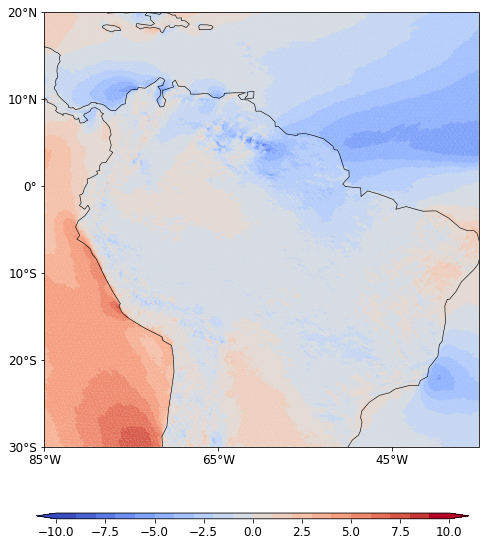

In [44]:
fig = plt.figure(figsize=(10, 8))
ax1=fig.add_axes([0.2,0.,0.6,0.01])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter((vas01[0,:]),int(3),ax,[-85,-35],[-30,20],[-10,10,20],'coolwarm','both','',\
                '',ax1,colorbar=True)

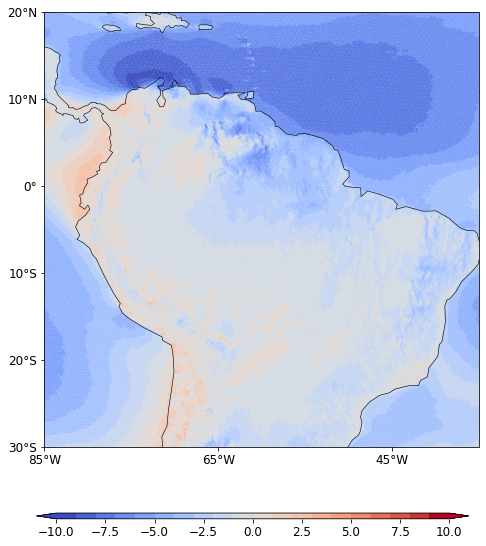

In [34]:
fig = plt.figure(figsize=(10, 8))
ax1=fig.add_axes([0.2,0.,0.6,0.01])
ax = fig.add_subplot(111,projection=ccrs.PlateCarree(central_longitude=225))
subplot_scatter((uas01[0,:]),int(3),ax,[-85,-35],[-30,20],[-10,10,20],'coolwarm','both','',\
                '',ax1,colorbar=True)

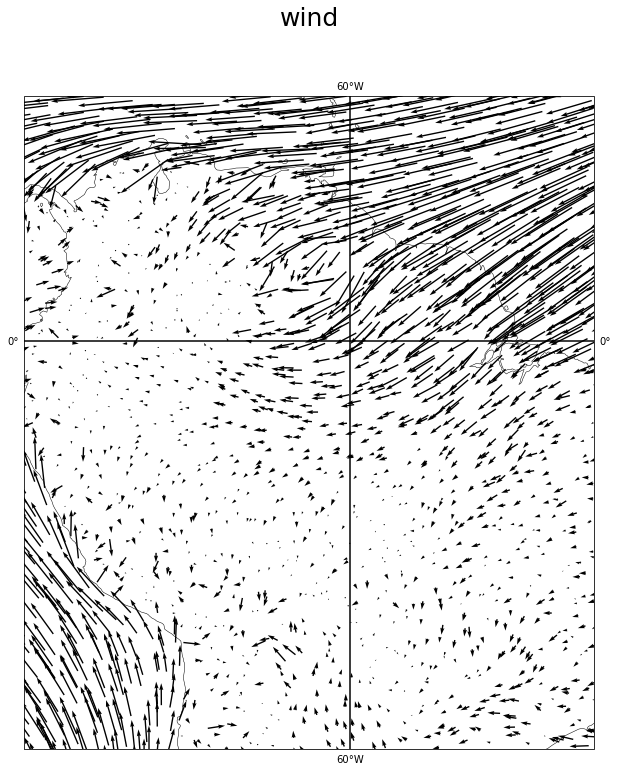

In [57]:
plot_windvector('wind', uas01, vas01, 400, -30, 20, 10, -85, -40, 20)

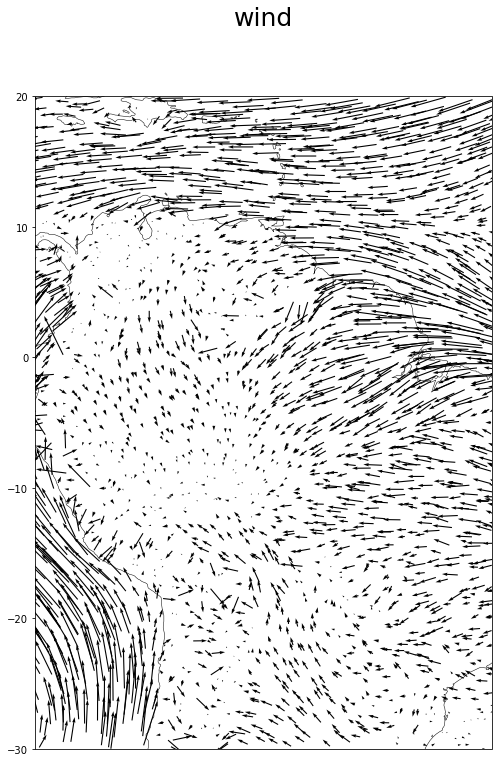

In [61]:
plot_windvector('wind', uas01, vas01, 400, -30, 20, 10, -85, -40, 20)